In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from halp.undirected_hypergraph import UndirectedHypergraph
from halp.utilities import undirected_graph_transformations, undirected_matrices
import scipy

## Example Hypergraph


#### Note:

Please see the notebook "erdos_renyi_centrality_correlations.ipynb" for full documentation of the functions used.

In [2]:
H = UndirectedHypergraph()
H.add_nodes([1,2,3,4,5,6,7,8,9,10])
H.add_hyperedge([1,2,3])
H.add_hyperedge([4,5,3])
H.add_hyperedge([3, 6])
H.add_hyperedge([6,7,8,9,10])

'e4'

In [3]:
node_map = undirected_matrices.get_node_mapping(H)[1]
edge_map = undirected_matrices.get_hyperedge_id_mapping(H)[1]

In [4]:
I = undirected_matrices.get_incidence_matrix(H, node_map, edge_map)
np.shape(I)

(10, 4)

In [5]:
I = I.toarray()
A = I.dot(I.T)

# Hyper-Incidence Matrix
A = A -np.diag(np.diag(A))

# Hyperedges Matrix
C = I.T.dot(I)
C_hat = np.diag(np.diag(C))

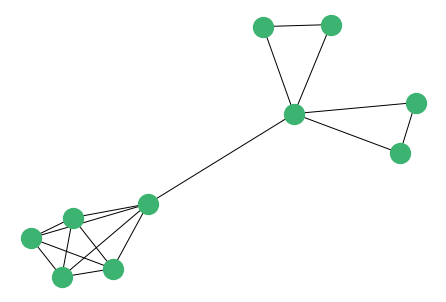

In [14]:
nx_graph = nx.from_numpy_matrix(A)
nx.draw_spring(nx_graph, node_color = "mediumseagreen", linewidths = 4)

plt.savefig("imgs/clique_graph.pdf", bbox_inches = "tight")

In [15]:
# PageRank functions

def power_iteration(A, num_simulations: int):

    # Code taken from "https://en.wikipedia.org/wiki/Power_iteration"
    b_k = np.random.rand(A.shape[1])

    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1, 1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

def hg_pagerank_power(T, alpha, num_sims):
    nodes = list(range(len(T)))
    n = len(nodes)

    T = alpha*T + (1-alpha)/n*np.ones((n,n)) # PageRank w/ teleportation
    
    res_pgrk = power_iteration(T.T, 100) # power method
    
    return res_pgrk

def hg_pagerank_full_eig_decomp(T, alpha):
    """
    
    Computes the pagerank for a Hypergraph H, for a random walk determined by transition matrix T.
    Computes by finding the left eigenvector associated to the eigenvalue \lambda = 1
    Does so by finding all eigenpairs of the matrix and then filtered
    (Takes long time for large matrices, see hg_pagerank_fast instead)
    
    """
    
    
    # p(t+1)_i = a * p(t)_i*T + (1-a)/n * 1
    
    nodes = list(range(len(T)))
    n = len(nodes)
    
    T = alpha*T + (1-alpha)/n*np.ones((n,n))
    
    # Find the right eigenvalue associated with the 1 eigenvalue (note the transpose of T)
    values, vectors = np.linalg.eig(T.T)
    vector = vectors[:,np.isclose(values, 1)] # find correct evector, code used from: 
    vector = vector[:,0]
    
    # normalise the stationary distribution
    stat_dist = vector / vector.sum()
    stat_dist = stat_dist.real
    
    
    #return the hypergraph PageRank
    return stat_dist


def find_pgrk(I, gamma, alpha):
    # compute the pagerank of the non-linear walker on hypergraph with incidence matrix I and bias parameter gamma
    
    # generate incidence matrix of hypergraph of N nodes, sqrt(N) hyperedges via E-R model
    
    # hyper-adjacency matrix
    A = I @ I.T
    # hyper-edges matrix
    C = I.T @ I
    
    # generate transition matrix for PageRank
    
    C_hat = np.diag(np.diag(C))

    K = np.zeros((len(A), len(A)))
    C_alt = np.diag(np.diag((C_hat - 1).astype(float)**gamma))
    C_alt = np.nan_to_num(C_alt, nan = 0, posinf = 0)

    K = (I @ C_alt @ I.T).astype(float)
    K = K - np.diag(np.diag(K)) # simple walk => remove diagonal entries


    T = np.zeros((len(A), len(A)))
    for i in range(len(A)):
        norm = np.sum(K[i])
        if norm ==0:
            pass
        else:
            T[i, :] = K[i] / norm
            
    #res_pgrk = hg_pagerank_power(T, alpha, 1000) # compute pagerank using power method, use for large matrices T
    res_pgrk = hg_pagerank_full_eig_decomp(T, alpha) # use eigendecomp when $\alpha = 1$ as more stable and for small graphs
    return res_pgrk 
    

In [29]:
gamma_list = np.linspace(-10, 10)
pgrk_results = []
pgrk_results_dict = {}

for gamma in gamma_list:
    pgrk_results.append(find_pgrk(I, gamma, 0.85))
    
# unpacking results for each node
for node in range(len(pgrk_results[0])):
    pgrk_results_dict[node] = [res[node] for res in pgrk_results]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in power


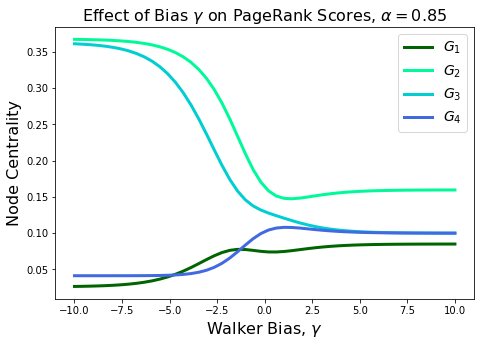

In [31]:
node_list = [0, 2, 5, 6] # select one node from each group


plt.figure(figsize = (7.5,5))

colors = {}
colors[0] = "darkgreen"
colors[2] = "mediumspringgreen"
colors[5] = "darkturquoise"
colors[6] = "royalblue"

for node in pgrk_results_dict:
    if node in node_list:
        plt.plot(gamma_list, pgrk_results_dict[node], color = colors[node], linewidth = 3)
    else:
        pass
        
    plt.legend(list(range(11)))
    
plt.title("Effect of Bias $\gamma$ on PageRank Scores, $\\alpha = 0.85$", fontsize = 16)
plt.xlabel("Walker Bias, $\gamma$", fontsize = 16)
plt.ylabel("Node Centrality", fontsize = 16)
plt.legend(["$G_1$", "$G_2$", "$G_3$", "$G_4$"], prop = {"size" : 14})
#plt.savefig("imgs/bias_PageRank_thicker_lines.pdf", bbox_inches = "tight")

In [32]:
gamma_list = np.linspace(-10, 10)
pgrk_results = []
pgrk_results_dict = {}

for gamma in gamma_list:
    pgrk_results.append(find_pgrk(I, gamma, 1))
    
# unpacking results for each node
for node in range(len(pgrk_results[0])):
    pgrk_results_dict[node] = [res[node] for res in pgrk_results]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in power


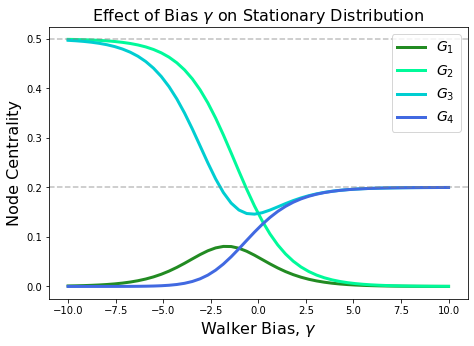

In [33]:
node_list = [0, 2, 5, 6] # select one node from each group

plt.figure(figsize = (7.5,5))

colors = {}
colors[0] = "forestgreen"
colors[2] = "mediumspringgreen"
colors[5] = "darkturquoise"
colors[6] = "royalblue"

for node in pgrk_results_dict:
    if node in node_list:
        plt.plot(gamma_list, pgrk_results_dict[node], color = colors[node], linewidth = 3)
    else:
        pass
        
    plt.legend(list(range(11)))
    
plt.title("Effect of Bias $\gamma$ on Stationary Distribution", fontsize = 16)
plt.xlabel("Walker Bias, $\gamma$", fontsize = 16)
plt.ylabel("Node Centrality", fontsize = 16)
plt.legend(["$G_1$", "$G_2$", "$G_3$", "$G_4$"], prop = {"size" : 14})
plt.axhline(1/2, linestyle = "--", alpha = 0.5, color = "gray")
plt.axhline(1/5, linestyle = "--", alpha = 0.5, color = "gray")
#plt.savefig("imgs/bias_stat_dist_thicker_lines.pdf", bbox_inches = "tight")

In [17]:
# checking power method is faster than np.eig

import time
alpha = 0.85
T = np.random.rand(1000, 1000)

s2 = time.time()
c_p = hg_pagerank_power(T, 0.85, 100)
e2 = time.time()

nodes = list(range(len(T)))
n = len(nodes)

T = alpha*T + (1-alpha)/n*np.ones((n,n))

s1 = time.time()
values, vectors = np.linalg.eig(T.T)
vector = vectors[:,np.isclose(values, values.max())] 
vector = np.real(vector[:,0])
e1 = time.time()

In [18]:
# checking they gave the same result 
np.linalg.norm(vector/np.sum(vector) - c_p)

1.877423716410504e-17

In [19]:
print(e1 - s1) # np.eig timing
print(e2 - s2) # power method

1.3669092655181885
0.04965829849243164


In [35]:
# finding which value of $\gamma$ the CEC centrality measure has the highest correlation with

# CEC node centrality

def compute_cec_ranking_svd(A):
    # using best rank one approximation
    rank = 1

    # Perform SVD on im and obtain individual matrices
    P, D, Q = np.linalg.svd(A, full_matrices=True)
    
    return np.abs(P[:, :rank].T[0])


c = compute_cec_ranking_svd(A)

In [36]:
c

array([0.05437461, 0.05437461, 0.16727684, 0.05437461, 0.05437461,
       0.46438521, 0.43143321, 0.43143321, 0.43143321, 0.43143321])

In [37]:
gamma_list = np.linspace(-5, 5, 300)
cec_gamma_correlation = [] # record the correlation between CEC centrality and the PageRank measure for different gamma.

for gamma in gamma_list:
    pgrk = find_pgrk(I, gamma, 0.85) # alpha = 0.85
    cec_gamma_correlation.append(np.corrcoef(c, pgrk)[0, 1])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in power


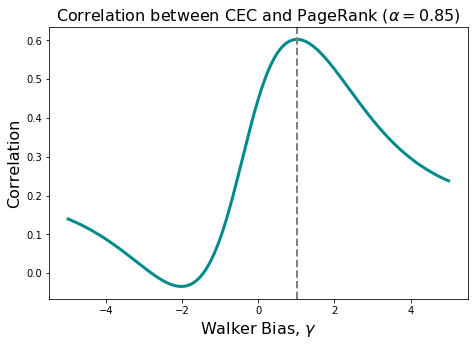

In [40]:
# from matplotlib import style
# style.use("seaborn")

plt.figure(figsize = (7.5,5))

plt.plot(gamma_list, cec_gamma_correlation, color = "darkcyan", linewidth = 3)
plt.xlabel("Walker Bias, $\gamma$", fontsize = 16)
plt.ylabel("Correlation", fontsize = 16)
plt.title("Correlation between CEC and PageRank ($\\alpha = 0.85$)", fontsize = 16)

plt.axvline(gamma_list[np.argmax(cec_gamma_correlation)], linestyle = "--", color = "gray", linewidth = 2)
#plt.savefig("imgs/corr_cec_pgrk_gamma.pdf", bbox_inches = "tight")

In [66]:
# finding the value of gamme the correlation achieves its highest value. 

gamma_list[np.argmax(cec_gamma_correlation)]

1.0200668896321066

#### Observing how changing $\alpha$ changes the correlation between the PageRank and CEC.

In [41]:
# record the correlation between CEC centrality and the PageRank measure for diff gamma and alpha


alpha_list = np.linspace(0.7, 1, 4)
gamma_list = np.linspace(-5, 5, 300)

res_dict = {}

for alpha in alpha_list:
    res_dict[alpha] = []

    for gamma in gamma_list:
        pgrk = find_pgrk(I, gamma, alpha) 
        res_dict[alpha].append(np.corrcoef(c, pgrk)[0, 1])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in power


In [42]:
legend_labels = ["$\\alpha = $" + str(np.round(alpha, 1)) for alpha in res_dict]

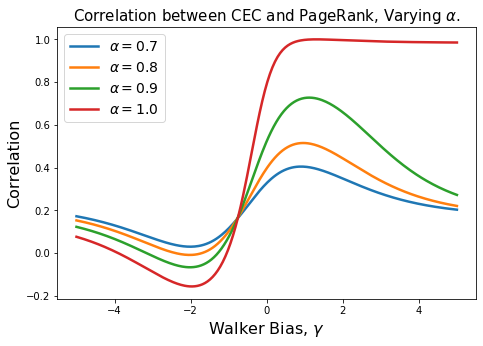

In [49]:
# from matplotlib import style
# style.use("seaborn")

plt.figure(figsize = (7.5,5))

for alpha in res_dict:
    plt.plot(gamma_list, res_dict[alpha], linewidth = 2.5)
plt.xlabel("Walker Bias, $\gamma$", fontsize = 16)
plt.ylabel("Correlation", fontsize = 16)
plt.title("Correlation between CEC and PageRank, Varying $\\alpha$.", fontsize = 15)
plt.legend(legend_labels, prop = {"size": 14})

#plt.axvline(gamma_list[np.argmax(cec_gamma_correlation)], linestyle = "--", color = "gray")
#plt.savefig("imgs/corr_cec_pgrk_var_alpha.pdf", bbox_inches = "tight")